С помощью pytorch подгрузим обученную сеть и протестируем ее на нескольких рандомных картинках


In [0]:
import torch
import torchvision as tv
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

In [0]:
model = tv.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [0]:
img = requests.get('http://astoriya74.ru/image/cache/catalog/2dobav/dreamstime_l_14774659-500x500.jpg').content

In [0]:
img = Image.open(BytesIO(img))

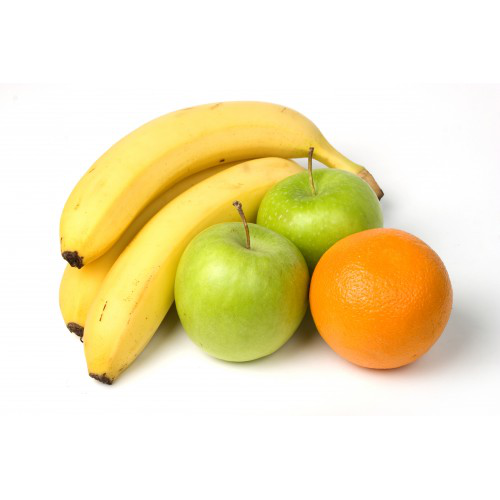

In [7]:
img

In [0]:
img_tens = tv.transforms.ToTensor()(img)

In [9]:
img_tens = img_tens.unsqueeze(dim=0)
img_tens.shape

torch.Size([1, 3, 500, 500])

In [10]:
model.eval()
ans = model(img_tens)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [11]:
ans

[{'boxes': tensor([[306.9421, 227.4641, 453.6494, 372.4762],
          [ 53.6741, 102.2439, 388.7300, 379.9483],
          [178.2326, 223.3074, 306.8434, 364.9743],
          [251.3761, 164.9411, 384.1840, 267.5238],
          [ 60.9826,  98.8594, 335.5603, 265.5211],
          [ 92.5563, 117.5007, 390.0148, 368.8441],
          [109.4660, 199.5233, 313.0749, 386.5869],
          [  0.0000,  51.0830, 500.0000, 456.8454],
          [ 36.9792, 108.0260, 413.0854, 407.2587],
          [184.0650, 164.3811, 376.0831, 301.7927],
          [ 58.3046, 259.0746, 105.7483, 335.0189],
          [ 69.9738, 176.5373, 295.3464, 380.7874],
          [178.8354, 167.7910, 429.0162, 369.2549],
          [100.6282,  96.6592, 385.4693, 205.6600]], grad_fn=<StackBackward>),
  'labels': tensor([55, 52, 53, 53, 52, 53, 53, 67, 51, 53, 52, 52, 55, 52]),
  'scores': tensor([0.9924, 0.9795, 0.9672, 0.9476, 0.5848, 0.4230, 0.3593, 0.3321, 0.3131,
          0.2093, 0.1611, 0.1186, 0.0703, 0.0560], grad_fn=<IndexB

In [0]:
ans_np = ans[0]['boxes'][ans[0]['scores'] > 0.7].detach().numpy()
ans_lab = ans[0]['labels'][ans[0]['scores'] > 0.7].detach().numpy()

In [0]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

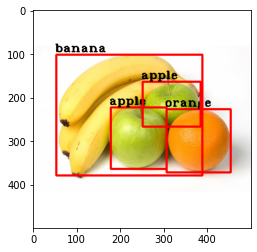

In [14]:
img_np = np.array(img)
for i in range(len(ans_np)):
    img_rec = cv2.rectangle(
        img_np,
        (ans_np[i][0], ans_np[i][1]),
        (ans_np[i][2], ans_np[i][3]),
         255, 3
    )

    cv2.putText(img_np, str(COCO_INSTANCE_CATEGORY_NAMES[ans_lab[i]]), (int(ans_np[i][0]-4), int(ans_np[i][1]-7)), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1.3, (0,0,0), 2)
plt.imshow(img_rec)


Для работы был выбран датасет с фруктами

*https://www.kaggle.com/mbkinaci/fruit-images-for-object-detection*

In [0]:
! unzip /content/34662_46346_bundle_archive.zip;

План!

1) Создать классы (наследуется от datasets)

2) Список картинок - переводим в тензор

3) Парсинг xml - получаем лейбл и координаты box'a 

4) Для передачи в loader преобразуем выход в x,y 

x - list тензоров, каждый тензор - картинка shape [Chanels, Hight, Wight] отнормированные от 0 до 1. Можно не ресайзить, но можно и ресайзить

y - list словарей

{Ключ 'boxes'} Cловарь содержит в себе boxes формы FloatTensor[N,4], где 4 - это координаты [x1, y1, x2, y2] - значения x (0,W), а значение y (0,H)

{Ключ 'labels'} Здесь только номер класса



In [0]:
class Fruts(torch.utils.data.Dataset):
    def __init__(self, folder):
        self.folder = folder
        self.p = Path(folder)
        self.p_train = self.p / 'train_zip' / 'train'
        self.train_jpg = sorted(list(p_train.glob('*.jpg')))
        self.train_xml = sorted(list(p_train.glob('*.xml')))

    def __len__(self):
        return len(self.train_jpg)

    def __getitem__(self):
        
        return images, labels
        

In [0]:
p = Path('/content')
p_train = p / 'train_zip' / 'train'
train_jpg = sorted(list(p_train.glob('*.jpg')))
train_xml = sorted(list(p_train.glob('*.xml')))

In [0]:
apple = train_jpg[0]

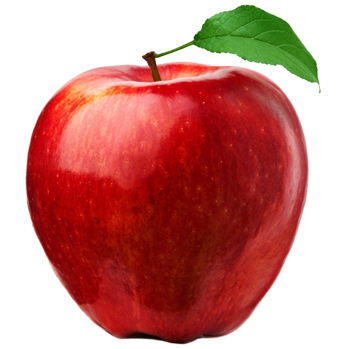

In [54]:
Image.open(apple)

In [0]:
apple_tensor = tv.transforms.ToTensor()(Image.open(apple))

In [53]:
print(apple_tensor.shape)

torch.Size([4, 349, 349])


In [0]:
img_apple = Image.open(apple).convert("RGB")

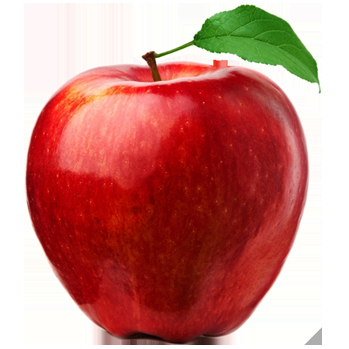

In [60]:
img_apple

In [59]:
(tv.transforms.ToTensor()(img_apple)).shape

torch.Size([3, 349, 349])